Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## Using the data by mounting the google drive, so using the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(f'{root_path}/Train')
data_dir_test = pathlib.Path(f'{root_path}/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [ ]:
## Writing the train dataset here
## Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    verbose = True
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [ ]:
## Writing the validation dataset here
## Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    verbose = True
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

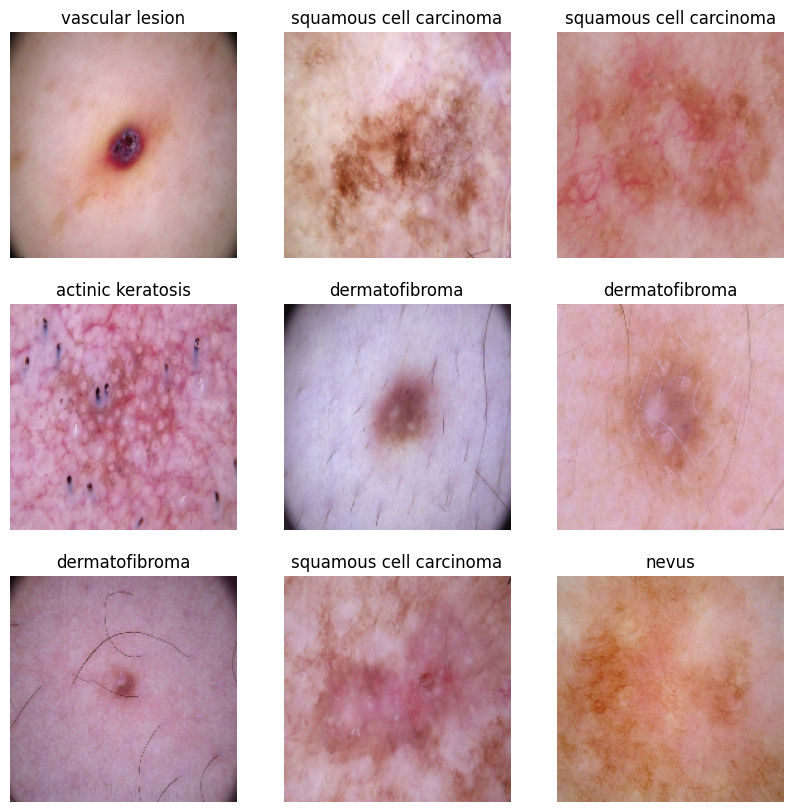

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Here, using ```layers.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# The pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9972223


In [ ]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compiling the model
Choosing an appropriate optimiser and loss function for model training

In [ ]:
### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.2864 - loss: 1.8607 - val_accuracy: 0.4824 - val_loss: 1.3542
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.5257 - loss: 1.2664 - val_accuracy: 0.6057 - val_loss: 1.0684
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.6572 - loss: 0.9568 - val_accuracy: 0.6142 - val_loss: 1.0998
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.7286 - loss: 0.7576 - val_accuracy: 0.7365 - val_loss: 0.7686
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.8043 - loss: 0.5589 - val_accuracy: 0.7957 - val_loss: 0.6004
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.8549 - loss: 0.4032 - val_accuracy: 0.7775 - val_loss: 0.6833
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.8815 - loss: 0.3283 - val_accuracy: 0.8371 - val_loss: 0.5521
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9082 - loss: 0.2660 - val_accu

### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As can be seen from the findings that the Training accuracy (85.36%) is much more than the Validation accuracy (53.47%). Thus, it is quite evident that the model overfits.

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_height),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
  layers.RandomWidth(0.2),
  layers.RandomHeight(0.2)
])

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

aug_train_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

aug_val_ds = val_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

  train_ds = prepare(train_ds, shuffle=True, augment=True)
  val_ds = prepare(val_ds)

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

The model clearly still overfits. In the next section, I will be adding dropout layer.

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
from skimage import io
import glob
import random

img_path = os.path.join(data_dir_train, class_names[1], '*')
img_path = glob.glob(img_path)

rand_index = random.randint(0, len(img_path))
image = io.imread(img_path[rand_index])
plt.imshow(image)
#img = tf.keras.preprocessing.image.load_img(flower_path[3], target_size=(img_height, img_width))

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(5):
    augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(f"Augmented {i+1}")
    plt.axis("off")

plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model still overfits. Now the training accuracy has reduced and validation accuracy is around the same value, so now the difference between the training and the validation accuracy has reduced.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from collections import Counter

# Counting occurrences of each class in the dataset
class_counts = Counter(label.numpy() for _, label in train_ds.unbatch())
class_counts = dict(sorted(class_counts.items()))

# Plotting the class distribution
plt.figure(figsize=(17, 6))
plt.bar(range(len(class_counts)), list(class_counts.values()), align='center')
plt.xticks(range(len(class_counts)), [class_names[i] for i in class_counts.keys()], rotation=45)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**The class 'seborrheic keratosis' has the least number of samples**.
#### - Which classes dominate the data in terms proportionate number of samples?
**The classes 'pigmented benign keratosis' and 'melanoma' have approximately same number of samples, so these classes dominate the data.**

*As can be seen from the graph, the four classes  namely, 'pigmented benign keratosis', 'melanoma', 'basal cell carcinoma' and 'nevus' dominate the data as their data is more in number as compared to the other five classes. The graph clearly shows the great imbalance between these.*


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
# Create a list to hold image paths and labels
image_paths = []
labels = []

# Iterate through each class subdirectory in the training directory
for class_dir in data_dir_train.iterdir():
    if class_dir.is_dir():  # Ensure it's a directory
        label = class_dir.name  # Get the label from the directory name
        for img_path in class_dir.glob('*.jpg'):  # Assuming your images are in .jpg format
            image_paths.append(str(img_path))  # Append image path
            labels.append(label)               # Append corresponding label

# Create a DataFrame from the lists
original_df = pd.DataFrame({'Path': image_paths, 'Label': labels})

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)
#new_df = original_df.concat(df2)

save_path = 'gdrive/My Drive/Colab Notebooks/Upgrad_assignments/new_df.csv'
new_df.to_csv(save_path, index=False)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train=save_path
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  #subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
The model is performing better now. The model is not overfitting as implementing class rebalance helped here.